- Started on July 31, 2019
- Works with a subset of the highd dataset
- Goal is to run particle filtering on this highd dataset with the
ultimate aim of learning idm rules for driver modeling

## Needs experimentation
- Should the particle fitness be based on likelihood of hallucinated x location
under Gaussian centered around true x location? Or should this also include
y? Reason for asking this question is because Frenet s is 0 all the time so
we will need to work with posG i.e. global position

## Needs investigation
- Why is Frenet s always 0?

In [1]:
using NGSIM
using AutomotiveDrivingModels
using AutoViz
using Interact # Make video in notebook
using Reel # Save video as gif
using CSV # For writing to csv
using DataFrames # For writing to csv
using PyPlot # For in notebook plotting
using Distributions
using Test

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-8640779364712014339\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-12477508767560951214\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/edf674b4a352d3049d1cf8e1b8f9eda882001cd6-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-8640779364712014339\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

In [3]:
# The trajectories i.e. positions of the cars with timestep
traj_highd = open(io->read(io, MIME"text/plain"(), Trajdata), 
    "trajdata_Data11_Road1_nLIOD3_lower.txt", "r");
# The highd roadway geometry
roadway_highd = open(io->read(io, MIME"text/plain"(), Roadway), 
    "ngsim_11_lower.txt", "r");

In [6]:
# Make a video replaying the highd trajectories on the roadway and save it into media
frames = Frames(MIME("image/png"), fps=10)
scene = Scene(500)
for i in 1:100
    temp_scene = get!(scene,traj_highd,i)
    carcolors = Dict{Int,Colorant}()
    for veh in temp_scene
        #@show veh.id
        #carcolors[veh.id] = in(veh.id, egoid) ? colorant"blue" : colorant"green"
        
            # Color cars green when they are in segment 3
        if veh.state.posF.roadind.tag.segment == 3
            carcolors[veh.id] = colorant"green"
        end
        
    end
    overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, 
                pos=VecSE2(veh.state.posG.x+0.5,veh.state.posG.y+0.5)) for veh in scene]
    scene_visual = render(temp_scene, roadway_highd, 
        #cam=CarFollowCamera{Int}(2,5.0),
        #cam=StaticCamera(VecE2(1966400, 570900), 5.0),
        cam=FitToContentCamera(0.),
        overlays,
        car_colors=carcolors)
    push!(frames,scene_visual)
end
write("media/highd_short.mp4",frames)

"media/highd_short.mp4"

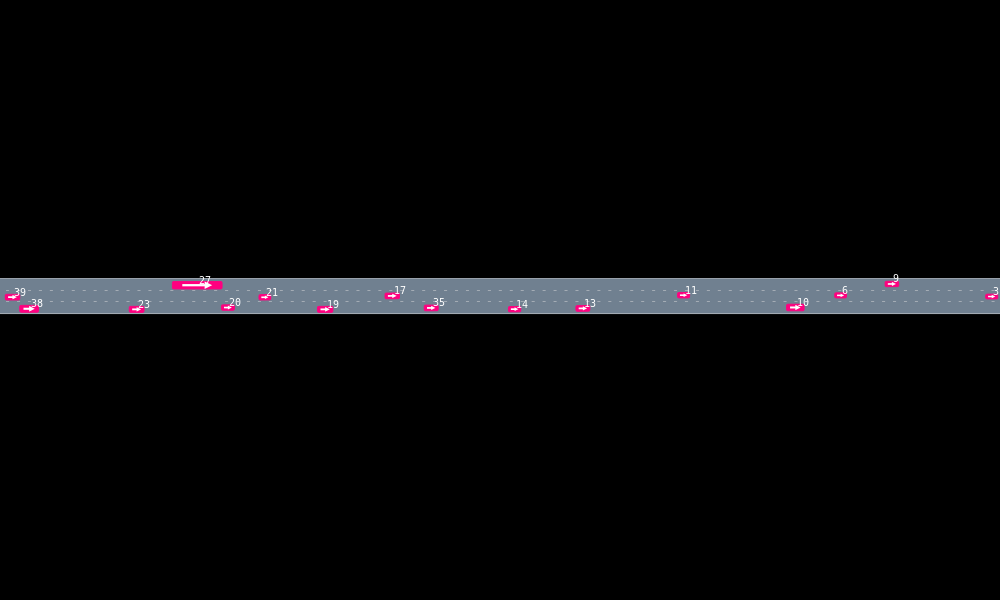

In [28]:
scene = Scene(500)
temp = get!(scene,traj_highd,30)
overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, 
                pos=VecSE2(veh.state.posG.x+0.5,veh.state.posG.y+0.5)) for veh in scene]
render(temp,roadway_highd,overlays)

In [30]:
for veh in temp
    print("veh id = $(veh.id)\n")
    #print("veh posF = $(veh.state.posF)\n")
    print("veh posG = $(veh.state.posG)\n")
end

veh id = 1
veh posG = VecSE2({399.420, 30.260}, 0.004)
veh id = 3
veh posG = VecSE2({335.800, 26.560}, 0.002)
veh id = 6
veh posG = VecSE2({285.430, 26.950}, -0.006)
veh id = 9
veh posG = VecSE2({302.530, 30.750}, 0.004)
veh id = 10
veh posG = VecSE2({270.340, 22.910}, 0.001)
veh id = 11
veh posG = VecSE2({233.090, 27.010}, -0.001)
veh id = 13
veh posG = VecSE2({199.520, 22.610}, 0.008)
veh id = 14
veh posG = VecSE2({176.760, 22.350}, 0.003)
veh id = 17
veh posG = VecSE2({135.980, 26.780}, 0.009)
veh id = 19
veh posG = VecSE2({113.610, 22.290}, 0.001)
veh id = 20
veh posG = VecSE2({81.190, 22.890}, -0.003)
veh id = 21
veh posG = VecSE2({93.520, 26.320}, 0.009)
veh id = 23
veh posG = VecSE2({50.770, 22.290}, -0.002)
veh id = 27
veh posG = VecSE2({70.970, 30.340}, -0.001)
veh id = 35
veh posG = VecSE2({148.960, 22.770}, 0.003)
veh id = 38
veh posG = VecSE2({14.940, 22.480}, 0.000)
veh id = 39
veh posG = VecSE2({9.390, 26.370}, 0.000)
